<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
! pip install optuna

import optuna

     |████████████████████████████████| 296kB 5.4MB/s 
     |████████████████████████████████| 1.1MB 6.9MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 481kB 13.5MB/s 
     |████████████████████████████████| 143kB 21.2MB/s 
     |████████████████████████████████| 112kB 18.4MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
  Created wheel for alembic: filename=alembic-1.5.3-py2.py3-none-any.whl size=155547 sha256=986d9492980530f87114005cf881b4410481af7eda722c8d28bfbec2e2246242
  Stored in directory: /root/.cache/pip/wheels/7f/ed/1b/a66a0cbca75fd3e374bd5cc60c443e5675f10ef1f1f78ec31d
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=cbc6c1656c01eabaee1e996d026d80a97896aa84352089772f15eae83f05d35d
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha2

In [ ]:
def funct(x):
  return (x**3+2**x*2+10+np.cos(x)+np.log(x**3))
size = 80
low=0
high=15
error=15

XX_train = np.random.uniform(low=low, high=high, size=size)
XX_test = np.random.uniform(low=low, high=high, size=size)
yy_train = funct(XX_train) + np.random.normal(0., error, size)
yy_test = funct(XX_test) + np.random.normal(0., error, size)

print(XX_train.shape, yy_train.shape)

(80,) (80,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



<function matplotlib.pyplot.show>

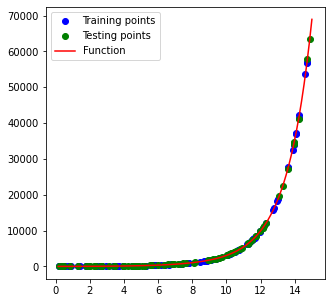

In [ ]:
fig = plt.figure(figsize=(5,5))

plt.plot(XX_train,yy_train, 'o', color='blue', label='Training points')
plt.plot(XX_test,yy_test, 'o', color='green', label='Testing points')

points = np.linspace(low, high,num=100)
plt.plot(points, funct(points),  color='red', label='Function')
plt.legend()


plt.show

In [ ]:
# Tutaj należy znormalizować dane, i.e. 
# - odjąć średnią
# - podzielić przez odchylenie standardowe
mean = XX_train.mean(axis=0)
XX_train_n = XX_train-mean
std = XX_train_n.std(axis=0)
XX_train_n /= std

# to samo dla x_test
XX_test_n = XX_test - mean
XX_test_n /= std

mean1 = yy_train.mean(axis=0)
yy_train_n = yy_train-mean1
std1 = yy_train_n.std(axis=0)
yy_train_n /= std1

# to samo dla y_test
yy_test_n = yy_test - mean1
yy_test_n /= std1

# A teraz to samo dla yy_train i yy_test
# dopisać to samo dla y

In [ ]:
# Zbudować sieć neuronową, działa: dwie warstwy ukryte, aktywacja relu
from keras import models
from keras import layers

In [ ]:
def objective(trial):
    units = trial.suggest_discrete_uniform('units', 8, 2048, 1)
    dropout = trial.suggest_uniform('dropout', 0, 0.5)
    lr = trial.suggest_float('lr',0.0005, 0.002, log=True)
    act= trial.suggest_categorical('activation',['relu','sigmoid','linear'])

    model0 = Sequential(name='network')
    #.....
    model0.add(layers.Dense(units, activation=act, input_shape=(1,)))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(units, activation=act))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(1, activation='linear'))
    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
    #model0.summary()
    opt=optimizers.RMSprop(lr=lr)
    model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
    history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
    results = model0.evaluate(XX_test_n, yy_test_n)
    return results[0]

In [ ]:
study = optuna.create_study()
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )

study.optimize(objective, n_trials=50)

study.best_params

[I 2021-02-01 22:30:31,097] A new study created in memory with name: no-name-f21b468a-934b-4432-9ea1-c595b0a3d64c
[I 2021-02-01 22:30:31,101] A new study created in memory with name: no-name-37ed0390-b9fe-48c3-b83a-37cb6fc8d327


Epoch 00296: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.4929 - mse: 0.4929


[I 2021-02-01 22:30:58,496] Trial 0 finished with value: 0.49289584159851074 and parameters: {'units': 497.0, 'dropout': 0.0612648972615929, 'lr': 0.000825615192370289, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.49289584159851074.


3/3 [==============================] - 0s 5ms/step - loss: 0.2986 - mse: 0.2986


[I 2021-02-01 22:31:46,576] Trial 1 finished with value: 0.2985610365867615 and parameters: {'units': 775.0, 'dropout': 0.1899720168441445, 'lr': 0.0017938768318885075, 'activation': 'sigmoid'}. Best is trial 1 with value: 0.2985610365867615.


Epoch 00056: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 1.9945 - mse: 1.9945


[I 2021-02-01 22:31:52,036] Trial 2 finished with value: 1.9945141077041626 and parameters: {'units': 670.0, 'dropout': 0.037946459312852565, 'lr': 0.0012298557763559816, 'activation': 'sigmoid'}. Best is trial 1 with value: 0.2985610365867615.


Epoch 00494: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.2003 - mse: 0.2003


[I 2021-02-01 22:32:37,730] Trial 3 finished with value: 0.20031443238258362 and parameters: {'units': 857.0, 'dropout': 0.06823847309056175, 'lr': 0.0011658525586176894, 'activation': 'sigmoid'}. Best is trial 3 with value: 0.20031443238258362.


Epoch 00077: early stopping
3/3 [==============================] - 0s 10ms/step - loss: 1.5365 - mse: 1.5365


[I 2021-02-01 22:32:50,139] Trial 4 finished with value: 1.5365369319915771 and parameters: {'units': 1862.0, 'dropout': 0.21472459106272596, 'lr': 0.0013256522525441513, 'activation': 'linear'}. Best is trial 3 with value: 0.20031443238258362.


Epoch 00388: early stopping
3/3 [==============================] - 0s 10ms/step - loss: 0.4244 - mse: 0.4244


[I 2021-02-01 22:33:51,599] Trial 5 finished with value: 0.4244031012058258 and parameters: {'units': 1956.0, 'dropout': 0.15642651703680904, 'lr': 0.0005464769160796934, 'activation': 'linear'}. Best is trial 3 with value: 0.20031443238258362.


Epoch 00154: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.4223 - mse: 0.4223


[I 2021-02-01 22:34:05,364] Trial 6 finished with value: 0.4222894310951233 and parameters: {'units': 761.0, 'dropout': 0.42915003241491406, 'lr': 0.0017951002203897347, 'activation': 'linear'}. Best is trial 3 with value: 0.20031443238258362.


Epoch 00077: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.4234 - mse: 0.4234


[I 2021-02-01 22:34:11,813] Trial 7 finished with value: 0.42344504594802856 and parameters: {'units': 129.0, 'dropout': 0.02050080061019477, 'lr': 0.0007274979039817641, 'activation': 'linear'}. Best is trial 3 with value: 0.20031443238258362.


Epoch 00471: early stopping
3/3 [==============================] - 0s 10ms/step - loss: 0.0082 - mse: 0.0082


[I 2021-02-01 22:35:17,379] Trial 8 finished with value: 0.008239629678428173 and parameters: {'units': 1657.0, 'dropout': 0.09874893969159787, 'lr': 0.0005728422480743982, 'activation': 'relu'}. Best is trial 8 with value: 0.008239629678428173.


3/3 [==============================] - 0s 4ms/step - loss: 0.1895 - mse: 0.1895


[I 2021-02-01 22:35:53,772] Trial 9 finished with value: 0.18949083983898163 and parameters: {'units': 198.0, 'dropout': 0.3194263685842846, 'lr': 0.0009310209598139201, 'activation': 'sigmoid'}. Best is trial 8 with value: 0.008239629678428173.


Epoch 00268: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.0245 - mse: 0.0245


[I 2021-02-01 22:36:27,856] Trial 10 finished with value: 0.024487342685461044 and parameters: {'units': 1417.0, 'dropout': 0.32023759189458273, 'lr': 0.0005101431251830363, 'activation': 'relu'}. Best is trial 8 with value: 0.008239629678428173.


Epoch 00437: early stopping
3/3 [==============================] - 0s 8ms/step - loss: 0.0036 - mse: 0.0036


[I 2021-02-01 22:37:21,626] Trial 11 finished with value: 0.003620004281401634 and parameters: {'units': 1422.0, 'dropout': 0.34932339868388984, 'lr': 0.0005034607117334515, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00385: early stopping
3/3 [==============================] - 0s 9ms/step - loss: 0.0059 - mse: 0.0059


[I 2021-02-01 22:38:06,358] Trial 12 finished with value: 0.005883184261620045 and parameters: {'units': 1384.0, 'dropout': 0.4461313412978966, 'lr': 0.0006154589949298548, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


3/3 [==============================] - 0s 7ms/step - loss: 0.0073 - mse: 0.0073


[I 2021-02-01 22:38:59,930] Trial 13 finished with value: 0.00726975966244936 and parameters: {'units': 1195.0, 'dropout': 0.4995774609642612, 'lr': 0.0006778811936121941, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00342: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.0246 - mse: 0.0246


[I 2021-02-01 22:39:37,470] Trial 14 finished with value: 0.02456059493124485 and parameters: {'units': 1288.0, 'dropout': 0.4125681339829269, 'lr': 0.0006461923560596609, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00421: early stopping
3/3 [==============================] - 0s 9ms/step - loss: 0.0197 - mse: 0.0197


[I 2021-02-01 22:40:32,486] Trial 15 finished with value: 0.0196564681828022 and parameters: {'units': 1599.0, 'dropout': 0.496985308313164, 'lr': 0.0005096293147447676, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00431: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.0121 - mse: 0.0121


[I 2021-02-01 22:41:16,383] Trial 16 finished with value: 0.012062564492225647 and parameters: {'units': 1073.0, 'dropout': 0.3255209746693384, 'lr': 0.000608960363316455, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00353: early stopping
3/3 [==============================] - 0s 8ms/step - loss: 0.0073 - mse: 0.0073    


[I 2021-02-01 22:42:01,762] Trial 17 finished with value: 0.007272600196301937 and parameters: {'units': 1508.0, 'dropout': 0.40765489923257364, 'lr': 0.0007973375646158905, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00420: early stopping
3/3 [==============================] - 0s 10ms/step - loss: 0.0079 - mse: 0.0079


[I 2021-02-01 22:42:59,887] Trial 18 finished with value: 0.007916385307908058 and parameters: {'units': 1740.0, 'dropout': 0.3748424653477739, 'lr': 0.000510407034446324, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00359: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.0094 - mse: 0.0094


[I 2021-02-01 22:43:41,335] Trial 19 finished with value: 0.009365935809910297 and parameters: {'units': 1335.0, 'dropout': 0.46524513542694135, 'lr': 0.0009879934319201816, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00249: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.0188 - mse: 0.0188


[I 2021-02-01 22:44:06,820] Trial 20 finished with value: 0.018834460526704788 and parameters: {'units': 1124.0, 'dropout': 0.25832006241609917, 'lr': 0.0015147076874673562, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00369: early stopping
3/3 [==============================] - 0s 8ms/step - loss: 0.0183 - mse: 0.0183


[I 2021-02-01 22:44:46,531] Trial 21 finished with value: 0.01827169395983219 and parameters: {'units': 1185.0, 'dropout': 0.48576958794800795, 'lr': 0.0007018819094846295, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00395: early stopping
3/3 [==============================] - 0s 8ms/step - loss: 0.0057 - mse: 0.0057


[I 2021-02-01 22:45:34,252] Trial 22 finished with value: 0.005745066795498133 and parameters: {'units': 1436.0, 'dropout': 0.3731056794730687, 'lr': 0.0006629643504578499, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00219: early stopping
3/3 [==============================] - 0s 11ms/step - loss: 0.0163 - mse: 0.0163


[I 2021-02-01 22:46:14,981] Trial 23 finished with value: 0.016279656440019608 and parameters: {'units': 2048.0, 'dropout': 0.35658008823640897, 'lr': 0.000600150721783964, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00391: early stopping
3/3 [==============================] - 0s 10ms/step - loss: 0.0047 - mse: 0.0047


[I 2021-02-01 22:46:54,507] Trial 24 finished with value: 0.004668378736823797 and parameters: {'units': 957.0, 'dropout': 0.2659319361557494, 'lr': 0.0008101679669551504, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00180: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.0193 - mse: 0.0193


[I 2021-02-01 22:47:13,860] Trial 25 finished with value: 0.01926259696483612 and parameters: {'units': 949.0, 'dropout': 0.26419255039422, 'lr': 0.0008253828408656584, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00492: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0077 - mse: 0.0077


[I 2021-02-01 22:47:53,774] Trial 26 finished with value: 0.007684702519327402 and parameters: {'units': 425.0, 'dropout': 0.2809234600013872, 'lr': 0.0009011053335992328, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00478: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.0049 - mse: 0.0049


[I 2021-02-01 22:48:39,894] Trial 27 finished with value: 0.004930431954562664 and parameters: {'units': 976.0, 'dropout': 0.3678476952322026, 'lr': 0.0007421275476900049, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00252: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.0128 - mse: 0.0128    


[I 2021-02-01 22:49:04,300] Trial 28 finished with value: 0.012761692516505718 and parameters: {'units': 959.0, 'dropout': 0.22635576784031555, 'lr': 0.001094501802152462, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00467: early stopping
3/3 [==============================] - 0s 4ms/step - loss: 0.0139 - mse: 0.0139


[I 2021-02-01 22:49:43,485] Trial 29 finished with value: 0.013896475546061993 and parameters: {'units': 564.0, 'dropout': 0.28588142855172943, 'lr': 0.0008034266846519711, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


3/3 [==============================] - 0s 3ms/step - loss: 0.0205 - mse: 0.0205


[I 2021-02-01 22:50:21,502] Trial 30 finished with value: 0.020507076755166054 and parameters: {'units': 373.0, 'dropout': 0.15389415330441641, 'lr': 0.0007622800556837193, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00339: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.0089 - mse: 0.0089


[I 2021-02-01 22:50:55,291] Trial 31 finished with value: 0.008939160034060478 and parameters: {'units': 1003.0, 'dropout': 0.3741500367237005, 'lr': 0.0009205049450971687, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00207: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.0111 - mse: 0.0111


[I 2021-02-01 22:51:22,522] Trial 32 finished with value: 0.0110847819596529 and parameters: {'units': 1521.0, 'dropout': 0.35736576834994593, 'lr': 0.0006720085907324949, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00055: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 1.5721 - mse: 1.5721


[I 2021-02-01 22:51:28,293] Trial 33 finished with value: 1.5721067190170288 and parameters: {'units': 843.0, 'dropout': 0.3064372522083613, 'lr': 0.0008714433328351814, 'activation': 'sigmoid'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00358: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.0130 - mse: 0.0130


[I 2021-02-01 22:52:09,368] Trial 34 finished with value: 0.013009073212742805 and parameters: {'units': 1244.0, 'dropout': 0.38219867522755196, 'lr': 0.0007495338177478846, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00058: early stopping
3/3 [==============================] - 0s 5ms/step - loss: 1.1759 - mse: 1.1759


[I 2021-02-01 22:52:15,196] Trial 35 finished with value: 1.1758636236190796 and parameters: {'units': 653.0, 'dropout': 0.34022703872575477, 'lr': 0.0010385654195390827, 'activation': 'sigmoid'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00321: early stopping
3/3 [==============================] - 0s 9ms/step - loss: 0.0092 - mse: 0.0092


[I 2021-02-01 22:53:00,201] Trial 36 finished with value: 0.009200473316013813 and parameters: {'units': 1750.0, 'dropout': 0.2327023830169334, 'lr': 0.0005500523588730818, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00081: early stopping
3/3 [==============================] - 0s 6ms/step - loss: 0.4341 - mse: 0.4341


[I 2021-02-01 22:53:07,900] Trial 37 finished with value: 0.4340505003929138 and parameters: {'units': 764.0, 'dropout': 0.19257074020477793, 'lr': 0.0006490461811173135, 'activation': 'linear'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00260: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.0297 - mse: 0.0297


[I 2021-02-01 22:53:31,645] Trial 38 finished with value: 0.02967877686023712 and parameters: {'units': 888.0, 'dropout': 0.4056695445853342, 'lr': 0.0007296925468626642, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00065: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.4314 - mse: 0.4314


[I 2021-02-01 22:53:38,797] Trial 39 finished with value: 0.4313625693321228 and parameters: {'units': 1059.0, 'dropout': 0.28797877793684123, 'lr': 0.0008626749178298024, 'activation': 'linear'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00055: early stopping
3/3 [==============================] - 0s 8ms/step - loss: 2.3938 - mse: 2.3938


[I 2021-02-01 22:53:46,105] Trial 40 finished with value: 2.393754243850708 and parameters: {'units': 1478.0, 'dropout': 0.3516707893340142, 'lr': 0.0005702206703318443, 'activation': 'sigmoid'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00362: early stopping
3/3 [==============================] - 0s 8ms/step - loss: 0.0089 - mse: 0.0089


[I 2021-02-01 22:54:27,723] Trial 41 finished with value: 0.008909305557608604 and parameters: {'units': 1373.0, 'dropout': 0.45086404585020357, 'lr': 0.0006108551212357398, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


3/3 [==============================] - 0s 9ms/step - loss: 0.0377 - mse: 0.0377


[I 2021-02-01 22:55:32,956] Trial 42 finished with value: 0.03774413466453552 and parameters: {'units': 1614.0, 'dropout': 0.43021513286153856, 'lr': 0.0006241440282464867, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


3/3 [==============================] - 0s 6ms/step - loss: 0.0073 - mse: 0.0073


[I 2021-02-01 22:56:24,484] Trial 43 finished with value: 0.007288294844329357 and parameters: {'units': 1151.0, 'dropout': 0.45487905602237494, 'lr': 0.000706642545893322, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00301: early stopping
3/3 [==============================] - 0s 9ms/step - loss: 0.0211 - mse: 0.0211


[I 2021-02-01 22:57:08,702] Trial 44 finished with value: 0.021059798076748848 and parameters: {'units': 1839.0, 'dropout': 0.3883552908419441, 'lr': 0.0005433883883305821, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00314: early stopping
3/3 [==============================] - 0s 8ms/step - loss: 0.0107 - mse: 0.0107


[I 2021-02-01 22:57:46,791] Trial 45 finished with value: 0.010661663487553596 and parameters: {'units': 1416.0, 'dropout': 0.43039683958814423, 'lr': 0.0007883355834077683, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00206: early stopping
3/3 [==============================] - 0s 9ms/step - loss: 0.0192 - mse: 0.0192


[I 2021-02-01 22:58:09,719] Trial 46 finished with value: 0.01920948177576065 and parameters: {'units': 1306.0, 'dropout': 0.3358983306380886, 'lr': 0.0006655556749089492, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00103: early stopping
3/3 [==============================] - 0s 7ms/step - loss: 0.4236 - mse: 0.4236


[I 2021-02-01 22:58:21,742] Trial 47 finished with value: 0.423553466796875 and parameters: {'units': 1255.0, 'dropout': 0.3089584477488111, 'lr': 0.0005680666915098629, 'activation': 'linear'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00423: early stopping
3/3 [==============================] - 0s 9ms/step - loss: 0.0044 - mse: 0.0044


[I 2021-02-01 22:59:18,724] Trial 48 finished with value: 0.00442211888730526 and parameters: {'units': 1679.0, 'dropout': 0.4726479394519477, 'lr': 0.0005271607886833372, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


Epoch 00461: early stopping
3/3 [==============================] - 0s 10ms/step - loss: 0.0052 - mse: 0.0052


[I 2021-02-01 23:00:30,149] Trial 49 finished with value: 0.005248677916824818 and parameters: {'units': 1930.0, 'dropout': 0.4792883217274158, 'lr': 0.0005007018548314398, 'activation': 'relu'}. Best is trial 11 with value: 0.003620004281401634.


{'activation': 'relu',
 'dropout': 0.34932339868388984,
 'lr': 0.0005034607117334515,
 'units': 1422.0}

In [ ]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [ ]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study, params=['units', 'dropout'])

In [ ]:
from optuna.visualization import plot_contour

plot_contour(study)

In [ ]:
plot_contour(study, params=['units', 'dropout'])

In [ ]:
from optuna.visualization import plot_slice
plot_slice(study)

In [ ]:
plot_slice(study, params=['units', 'dropout'])

In [ ]:
from optuna.visualization import plot_param_importances
plot_param_importances(study)

In [ ]:
trial = study.best_trial
units = int(trial.params.get('units'))
dropout = (trial.params.get('dropout'))
print(units)
print(dropout)

1422
0.34932339868388984


In [ ]:
model0 = Sequential(name='network')
    #.....
model0.add(layers.Dense(units, activation='relu', input_shape=(1,)))
model0.add(Dropout(dropout))
model0.add(layers.Dense(units, activation='relu'))
model0.add(Dropout(dropout))
model0.add(layers.Dense(1, activation='linear'))
# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
#model0.summary()
opt=optimizers.RMSprop(lr=0.001)
model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=200,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
results = model0.evaluate(XX_test_n, yy_test_n)

3/3 [==============================] - 0s 7ms/step - loss: 0.0264 - mse: 0.0264


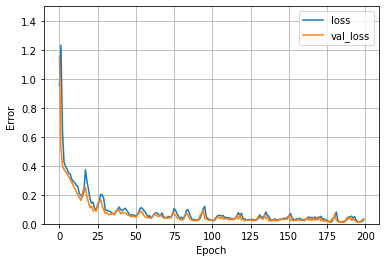

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error ')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
results = model0.evaluate(XX_test_n, yy_test_n)

print('loss test data: ', results[0])
print('mse test data: ', results[1])

results = model0.evaluate(XX_train_n, yy_train_n)

print('loss train data: ', results[0])
print('mse train data: ', results[1])

3/3 [==============================] - 0s 8ms/step - loss: 0.0264 - mse: 0.0264
loss test data:  0.026415834203362465
mse test data:  0.026415834203362465
3/3 [==============================] - 0s 8ms/step - loss: 0.0380 - mse: 0.0380
loss train data:  0.03804214671254158
mse train data:  0.03804214671254158


<function matplotlib.pyplot.show>

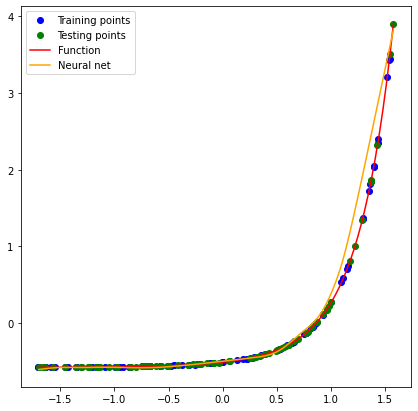

In [ ]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train_n,yy_train_n, 'o', color='blue', label='Training points')
plt.plot(XX_test_n,yy_test_n, 'o', color='green', label='Testing points')

points = np.linspace(min(XX_test_n), max(XX_test_n),num=100)
plt.plot(points, (funct(points*std+mean)-mean1)/std1,  color='red', label='Function')

plt.plot(points, model0.predict(points),  color='orange', label='Neural net')


plt.legend()


plt.show